In [1]:
%reload_ext autoreload
%autoreload 2

# 导入所有的包
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import tensorflow as tf
import tensorflow.contrib.slim as slim
import os 
import csv
from library.load_dataset import load_list,read_data
import matplotlib.pyplot as plt


os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'



/home/weijia.wu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 导入数据

In [2]:
image_dir = '/home/weijia.wu/workspace/TensorFlow/Tensorflow_Deeplearning/CNN/dataset/train_valid/'
list_path = '/home/weijia.wu/workspace/TensorFlow/Tensorflow_Deeplearning/CNN/dataset/driver_imgs_list.csv'

image_names, image_labels = load_list(image_dir,list_path)     #读取数据list
print(len(image_names),len(image_labels))

22424 22424


In [3]:
image_labels[100]

1

# 数据分析

In [4]:
with tf.Session() as sess:
    test_onehot = tf.one_hot(image_labels,10)
    test_onehot = sess.run(test_onehot)

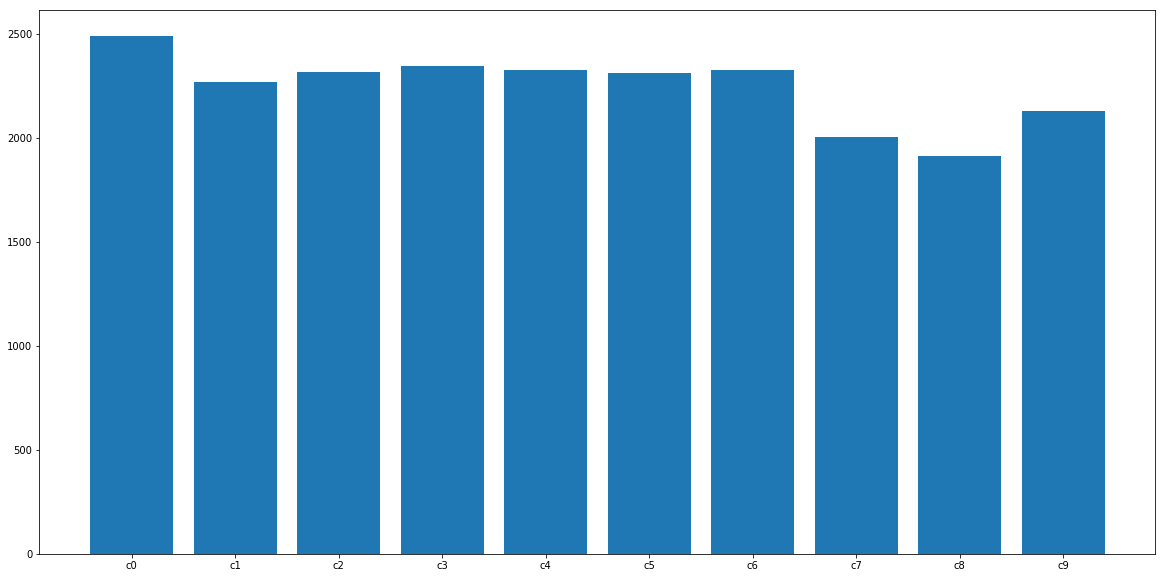

[2489.0, 2267.0, 2317.0, 2346.0, 2326.0, 2312.0, 2325.0, 2002.0, 1911.0, 2129.0]


In [5]:

def panda_data(label):
    number_list = label
    num_list = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
    plt.figure(figsize=(20,10))
    plt.bar(range(len(number_list)), number_list, tick_label = num_list)
    plt.show()

col = map(sum,zip(*test_onehot))   #按列相加
panda_data(col)
print(col)

# 创建数据dataset并进行数据处理

In [6]:
# NUM_EXAMPLES_OF_TRAIN = 20000
# NUM_EXAMPLES_OF_VALID = len(image_names) - NUM_EXAMPLES_OF_TRAIN

# train_names, train_labels = image_names[:NUM_EXAMPLES_OF_TRAIN], image_labels[:NUM_EXAMPLES_OF_TRAIN]
# valid_names, valid_labels = image_names[NUM_EXAMPLES_OF_TRAIN:], image_labels[NUM_EXAMPLES_OF_TRAIN:]


from sklearn.model_selection import  train_test_split
train_names,valid_names,train_labels,valid_labels = train_test_split(image_names,image_labels,test_size = 0.2,random_state=42)

NUM_EXAMPLES_OF_TRAIN = len(train_names)
NUM_EXAMPLES_OF_VALID = len(image_names) - NUM_EXAMPLES_OF_TRAIN


In [7]:
batch_size = 10

train_images, train_labels = read_data(train_names, train_labels, batch_size=batch_size, shuffle=True, phase='train')
valid_images, valid_labels = read_data(valid_names, valid_labels, batch_size=batch_size, shuffle=False, phase='valid')

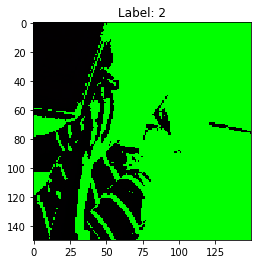

In [8]:
# 测试
# =========这里不要修改=========
import numpy as np

with tf.Session() as sess:
    img_fetch, label_fetch = sess.run([train_images, train_labels])
    assert img_fetch.ndim == 4, '图像维数 != 4'
    assert label_fetch.ndim == 1, '标签维数 != 1'
    plt.imshow(np.uint8(img_fetch[0]))
    plt.title('Label: %d' % label_fetch[0])

# 构建模型

In [9]:
from tensorflow.contrib.slim.python.slim.nets import resnet_v2

def model(inputs, num_classes, is_training=False, scope='model', reuse=None):
    '''
    function to build forward model.
    
    Arguments:
      inputs: 4维输入图像tensor.
              
      num_classes: 分类数.
                   
      is_training: 对使用 BN 层的神经网络非常有用, 你可以使用它或者不使用.
                   
      scope: 变量域的名称.
             
      reuse: 是否需要重用该变量域下的变量.
      
    Return:
      output: 预测模型在使用最后一个 softmax 或者 sigmoid 之前的输出.
    '''
    #TODO
    # 构造你自己的预测模型
    
    with slim.arg_scope(resnet_v2.resnet_arg_scope(weight_decay=0.0005)):
        logits, endpts = resnet_v2.resnet_v2_50(inputs, num_classes, is_training=is_training, reuse=reuse, scope=scope)
    output = tf.squeeze(logits, [1, 2], name='Output')
    
    return output

# 正则化

In [10]:
with slim.arg_scope([slim.conv2d], activation_fn=tf.nn.relu, normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.conv2d, slim.fully_connected], weights_regularizer = slim.regularizers.l2_regularizer(1e-3)) as sc:
        conv_scope = sc

In [11]:
is_training = tf.placeholder(tf.bool, name='is_training')

with slim.arg_scope(conv_scope):
    train_out = model(train_images, num_classes=10, is_training=is_training)
    valid_out = model(valid_images, num_classes=10, is_training=is_training, reuse=True)

# 构建 loss 函数,计算正确率和构造优化算法

In [12]:
#TODO
# 计算 loss

train_loss = tf.losses.sparse_softmax_cross_entropy(train_labels, train_out)
valid_loss = tf.losses.sparse_softmax_cross_entropy(valid_labels, valid_out)

In [13]:
#TODO
# 计算概率

train_prob = tf.nn.softmax(train_out)
valid_prob = tf.nn.softmax(valid_out)

In [14]:
#TODO
# 计算 accuracy

train_acc = tf.reduce_mean(tf.cast(tf.equal(train_labels, tf.argmax(train_prob, axis=-1, output_type=tf.int32)), dtype=tf.float32))
valid_acc = tf.reduce_mean(tf.cast(tf.equal(valid_labels, tf.argmax(valid_prob, axis=-1, output_type=tf.int32)), dtype=tf.float32))

In [15]:
#TODO
# 定义优化方法

opt = tf.train.AdamOptimizer(0.001, 0.9)

#TODO
# 得到所有 bn 更新算子

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

#TODO
# 构造训练方法

with tf.control_dependencies(update_ops):
    train_op = opt.minimize(train_loss)

# 训练

In [16]:
from library.trianing import train

sessing....
INFO:tensorflow:Restoring parameters from /home/weijia.wu/workspace/Kaggle/State_farm_distracted_driver_detection/resnet_v2_50_2017_04_14/resnet_v2_50.ckpt
train....
[2000]/[20000], train loss: 1.972, train acc: 0.316
[4000]/[20000], train loss: 1.751, train acc: 0.386
[6000]/[20000], train loss: 1.577, train acc: 0.452
[8000]/[20000], train loss: 1.444, train acc: 0.504
[10000]/[20000], train loss: 1.351, train acc: 0.538
[12000]/[20000], train loss: 1.280, train acc: 0.562
[14000]/[20000], train loss: 1.226, train acc: 0.581
[16000]/[20000], train loss: 1.172, train acc: 0.600
[18000]/[20000], train loss: 1.131, train acc: 0.614
[20000]/[20000], train loss: 1.100, train acc: 0.624
epoch: 1, train loss: 1.100, train acc: 0.624, valid loss: 1.916, valid acc: 0.393
()
[2000]/[20000], train loss: 0.757, train acc: 0.746
[4000]/[20000], train loss: 0.750, train acc: 0.752
[6000]/[20000], train loss: 0.682, train acc: 0.773
[8000]/[20000], train loss: 0.641, train acc: 0.788
[1

[6000]/[20000], train loss: 0.178, train acc: 0.945
[8000]/[20000], train loss: 0.159, train acc: 0.950
[10000]/[20000], train loss: 0.158, train acc: 0.949
[12000]/[20000], train loss: 0.163, train acc: 0.947
[14000]/[20000], train loss: 0.163, train acc: 0.947
[16000]/[20000], train loss: 0.163, train acc: 0.948
[18000]/[20000], train loss: 0.163, train acc: 0.947
[20000]/[20000], train loss: 0.162, train acc: 0.948
epoch: 14, train loss: 0.162, train acc: 0.948, valid loss: 1.119, valid acc: 0.607
()
[2000]/[20000], train loss: 0.169, train acc: 0.939
[4000]/[20000], train loss: 0.155, train acc: 0.947
[6000]/[20000], train loss: 0.152, train acc: 0.948
[8000]/[20000], train loss: 0.135, train acc: 0.954
[10000]/[20000], train loss: 0.141, train acc: 0.952
[12000]/[20000], train loss: 0.141, train acc: 0.952
[14000]/[20000], train loss: 0.144, train acc: 0.952
[16000]/[20000], train loss: 0.146, train acc: 0.951
[18000]/[20000], train loss: 0.147, train acc: 0.950
[20000]/[20000], t

[16000]/[20000], train loss: 0.085, train acc: 0.973
[18000]/[20000], train loss: 0.090, train acc: 0.971
[20000]/[20000], train loss: 0.089, train acc: 0.971
epoch: 27, train loss: 0.089, train acc: 0.971, valid loss: 1.202, valid acc: 0.632
()
[2000]/[20000], train loss: 0.095, train acc: 0.967
[4000]/[20000], train loss: 0.094, train acc: 0.969
[6000]/[20000], train loss: 0.093, train acc: 0.971
[8000]/[20000], train loss: 0.082, train acc: 0.975
[10000]/[20000], train loss: 0.082, train acc: 0.974
[12000]/[20000], train loss: 0.082, train acc: 0.974
[14000]/[20000], train loss: 0.082, train acc: 0.974
[16000]/[20000], train loss: 0.086, train acc: 0.973
[18000]/[20000], train loss: 0.087, train acc: 0.972
[20000]/[20000], train loss: 0.087, train acc: 0.972
epoch: 28, train loss: 0.087, train acc: 0.972, valid loss: 1.336, valid acc: 0.638
()
[2000]/[20000], train loss: 0.081, train acc: 0.970
[4000]/[20000], train loss: 0.079, train acc: 0.972
[6000]/[20000], train loss: 0.075, tr

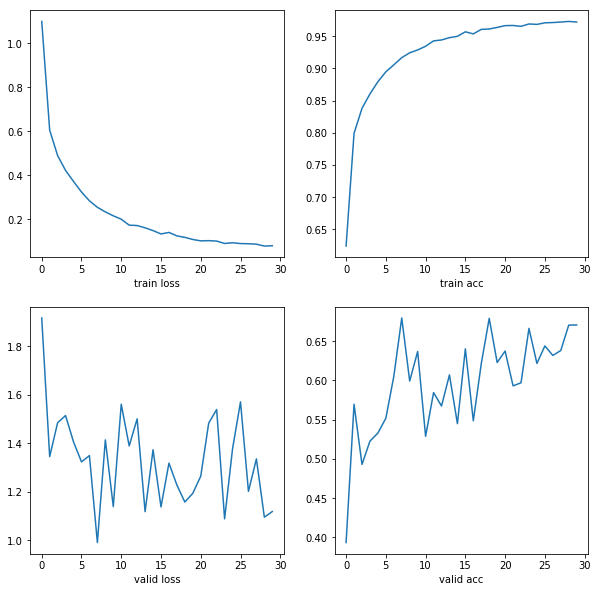

In [18]:
train(train_op, train_loss, train_acc, 30, is_training, valid_loss, valid_acc, save_path='tmp', pretrained_model='/home/weijia.wu/workspace/Kaggle/State_farm_distracted_driver_detection/resnet_v2_50_2017_04_14/resnet_v2_50.ckpt')

# 预测数据集

In [20]:
import pandas as pd 
import os
import numpy as np
from library.test_data import read_test,predict_result

In [21]:
tf.reset_default_graph()

In [22]:
import tensorflow.contrib.slim as slim
import tensorflow as tf

In [25]:

test_name,test_images = read_test('/home/weijia.wu/workspace/TensorFlow/Tensorflow_Deeplearning/CNN/dataset/test/')
submission = predict_result(test_images,test_name,'/home/weijia.wu/workspace/Kaggle/State_farm_distracted_driver_detection/tmp/model.ckpt',model)

INFO:tensorflow:Restoring parameters from /home/weijia.wu/workspace/Kaggle/State_farm_distracted_driver_detection/tmp/model.ckpt
1000 done!
2000 done!
3000 done!
4000 done!
5000 done!
6000 done!
7000 done!
8000 done!
9000 done!
10000 done!
11000 done!
12000 done!
13000 done!
14000 done!
15000 done!
16000 done!
17000 done!
18000 done!
19000 done!
20000 done!
21000 done!
22000 done!
23000 done!
24000 done!
25000 done!
26000 done!
27000 done!
28000 done!
29000 done!
30000 done!
31000 done!
32000 done!
33000 done!
34000 done!
35000 done!
36000 done!
37000 done!
38000 done!
39000 done!
40000 done!
41000 done!
42000 done!
43000 done!
44000 done!
45000 done!
46000 done!
47000 done!
48000 done!
49000 done!
50000 done!
51000 done!
52000 done!
53000 done!
54000 done!
55000 done!
56000 done!
57000 done!
58000 done!
59000 done!
60000 done!
61000 done!
62000 done!
63000 done!
64000 done!
65000 done!
66000 done!
67000 done!
68000 done!
69000 done!
70000 done!
71000 done!
72000 done!
73000 done!
7400

In [26]:
idx_to_class = {}
for i in range(10):
    idx_to_class[i] = 'c%d' % i

In [27]:
submission.columns = [['img'] + [i for i in idx_to_class.values()]]

In [28]:
submission.to_csv('./submission.csv', index=False)

# 自动划分训练集和测试集

In [3]:
import numpy as np
# 正态分布生成原始数据
x = np.random.normal(1,0.1,100)
# 按8:2分割数据
# x_train_index = np.random.choice(len(x),round(len(x)*0.8),replace = False)
# x_valid_index = np.array(list(set(range(len(x))) - set(x_train_index)))

# x_train = x[x_train_index]
# x_valid = x[x_valid_index]
x

array([0.97917312, 1.09524264, 0.9661778 , 0.95449431, 1.04305825,
       0.99531452, 1.14467802, 0.77014781, 1.03741049, 0.78262269,
       1.07096649, 1.08475027, 1.17487973, 1.04707371, 1.08505945,
       1.01686259, 0.91193381, 1.06776786, 1.03551245, 0.86049137,
       0.99200195, 1.07811484, 1.13396161, 0.88047065, 1.15685144,
       0.95369148, 0.95351455, 1.09521739, 0.99477195, 0.95697295,
       0.96969119, 1.06855116, 0.93135976, 1.02270673, 1.08146143,
       0.94639083, 1.08397386, 1.04157172, 0.87632596, 0.97799582,
       0.981047  , 0.80590779, 1.04193223, 1.13990858, 1.03335999,
       0.8212618 , 1.10764786, 1.12738561, 0.91222671, 0.73472432,
       0.88794317, 0.88202768, 0.98685883, 1.01998712, 1.01855224,
       1.08626744, 1.26630488, 1.01287348, 1.06814386, 0.98540805,
       0.93858386, 0.9777675 , 0.93730551, 1.12141391, 0.94846291,
       1.06946469, 1.00223055, 1.17081318, 0.97519595, 0.8252117 ,
       0.96472183, 1.07545659, 1.08561879, 1.06899508, 0.91261

In [9]:
x_train_index = np.random.choice(len(x),int(round(len(x)*0.8)),replace = False)
x_train_index

array([19, 10, 41, 79, 39, 77, 27, 22, 34,  6, 29,  5, 51, 72, 50,  3, 54,
        0, 48, 40, 62, 86,  8, 73, 28, 74, 21, 26, 36, 57, 66, 93, 17, 82,
       69, 92,  9, 20, 96, 13, 52, 68, 56, 97, 78, 53, 14, 94, 87, 67, 47,
       24,  2, 11, 42, 15, 59, 89, 25, 49, 58, 32, 98, 23, 55, 85,  7,  4,
       44, 38, 81, 75, 37, 83, 95, 63, 30, 80, 91, 60])

In [10]:
# x_train_index = np.random.choice(len(x),round(len(x)*0.8),replace = False)
x_valid_index = np.array(list(set(range(len(x))) - set(x_train_index)))
x_valid_index

array([64,  1, 35, 70, 65, 33, 76, 43, 12, 45, 46, 16, 90, 18, 99, 84, 88,
       71, 61, 31])

In [12]:
x_train = x[x_train_index]
x_valid = x[x_valid_index]
print(x_train,x_valid)

(array([0.86049137, 1.07096649, 0.80590779, 0.84564777, 0.97799582,
       0.94754764, 1.09521739, 1.13396161, 1.08146143, 1.14467802,
       0.95697295, 0.99531452, 0.88202768, 1.08561879, 0.88794317,
       0.95449431, 1.01855224, 0.97917312, 0.91222671, 0.981047  ,
       0.93730551, 1.15511026, 1.03741049, 1.06899508, 0.99477195,
       0.91261816, 1.07811484, 0.95351455, 1.08397386, 1.01287348,
       1.00223055, 0.96620728, 1.06776786, 1.02835601, 0.8252117 ,
       0.87683563, 0.78262269, 0.99200195, 0.90573769, 1.04707371,
       0.98685883, 0.97519595, 1.26630488, 1.10499017, 1.13796013,
       1.01998712, 1.08505945, 0.77241079, 1.02109049, 1.17081318,
       1.12738561, 1.15685144, 0.9661778 , 1.08475027, 1.04193223,
       1.01686259, 0.98540805, 0.94890443, 0.95369148, 0.73472432,
       1.06814386, 0.93135976, 1.13077231, 0.88047065, 1.08626744,
       0.86756951, 0.77014781, 1.04305825, 1.03335999, 0.87632596,
       0.99456972, 1.04318375, 1.04157172, 0.79930507, 0.7886